In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from model_prediction import Replicator
from pneumococcus_data import data_observation
from subsystem import alpha_extract

In [2]:
Iran, Denmark, Brazil, Nepal, Mozambique = data_observation()

big_alpha_Jan = np.loadtxt(open("big_alpha_Jan.txt","rb"), delimiter = ",", skiprows = 0)
big_alpha_May = np.loadtxt(open("big_alpha_May.txt","rb"), delimiter = ",", skiprows = 0)

## Estimation errors

In [3]:
def compute_prediction(strain_number, alpha_matrix, mu):
    #compute fitness matrix
    lambd = np.zeros((strain_number, strain_number))
    for k in range (0, strain_number):
        for j in range (0, strain_number):
            lambd[k][j] = mu*(alpha_matrix[j][k] - alpha_matrix[k][j]) + alpha_matrix[j][k] - alpha_matrix[j][j]
    
    if mu > 4:
        #initial values
        u0 = (1/strain_number)*np.ones(strain_number)
        
        #compute solution of replicator dynamics
        predict_solution = Replicator(strain_number, lambd, 50, u0)
        
    else:
        one = np.ones(strain_number) #vector of all ones
        inv = np.linalg.inv(lambd) #inverse matrix of fitness matrix
        
        #equilibrium of predicted model
        predict_solution = (1/np.matmul(one.T, np.matmul(inv, one)))*np.matmul(inv, one)
    
    return predict_solution

In [4]:
#compute solution of predicted model (replicator dynamics/ stable equilibrium)
country = [Iran, Nepal, Brazil, Denmark, Mozambique]
mu_list = [0.93, 3.95, 9.85, 10.23, 16.8]
big_alpha = [big_alpha_Jan, big_alpha_May]

Jan = []
May = []
model_solution = [Jan, May]
strain_number_list = []

err_Jan = []
err_May = []
MSE = [err_Jan, err_May]

for j in range (0, 2):
    for i in range (0, 5):
        #extract data for each country
        strain_list = np.array(country[i].strain)
        strain_number = len(strain_list)
        strain_number_list.append(strain_number)
    
        #extract alpha matrix from big alpha
        alpha_matrix = alpha_extract(strain_list, big_alpha[j])
        mu = mu_list[i]
        predict_solution = compute_prediction(strain_number, alpha_matrix, mu)
        err = np.linalg.norm(predict_solution - np.array(country[i].cases))/np.sqrt(strain_number)
        
        model_solution[j].append(predict_solution)
        MSE[j].append(err)

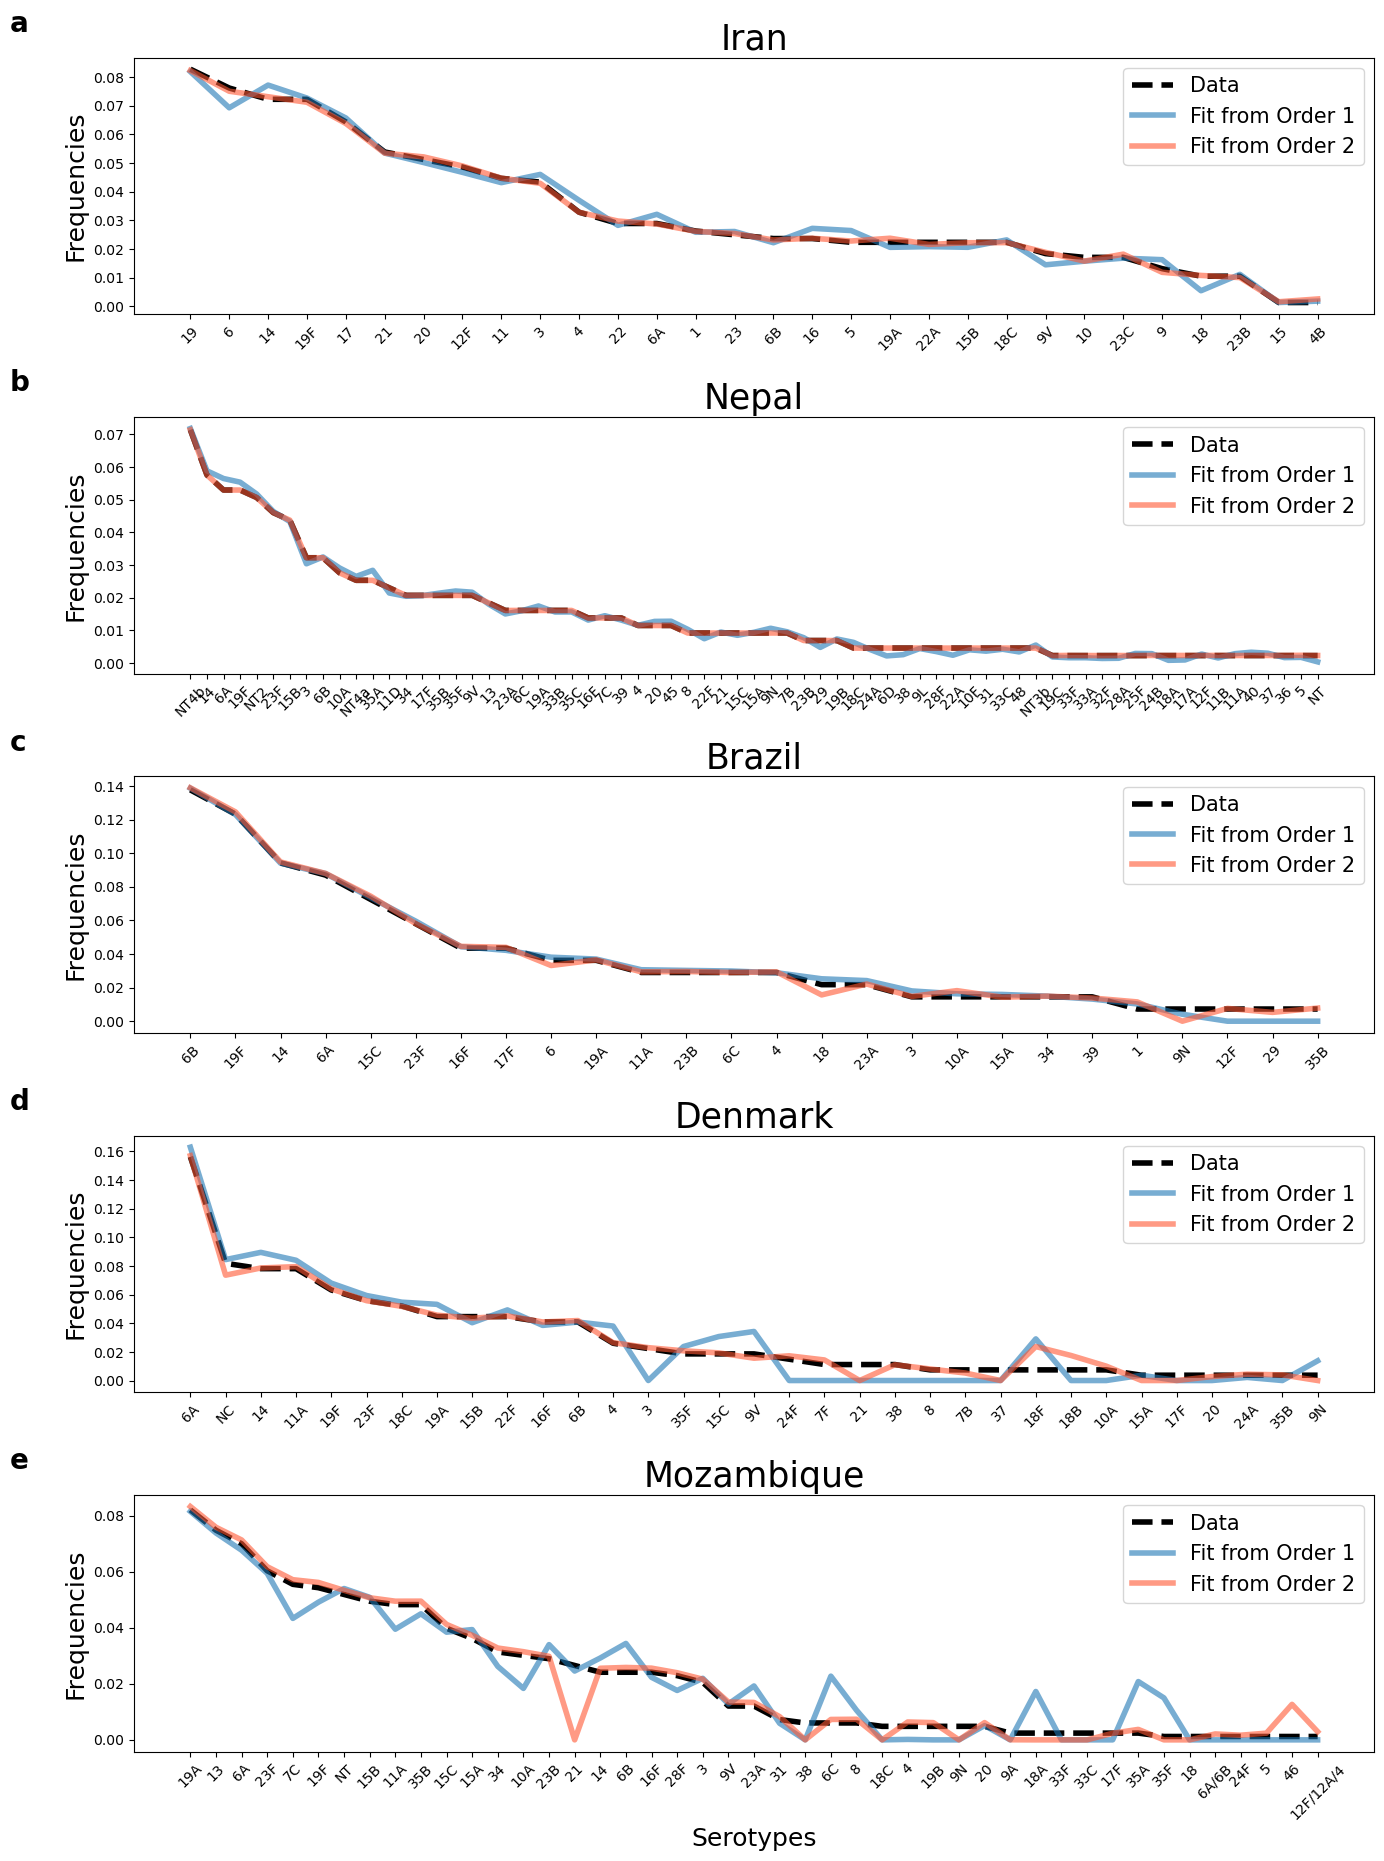

In [5]:
fig, ax = plt.subplots(5, 1, figsize = (16, 22))
fig.subplots_adjust(hspace = 0.4)
name_country = ['Iran', 'Nepal', 'Brazil', 
                'Denmark', 'Mozambique']
label = ['a', 'b', 'c', 'd', 'e']

for i in range (0, 5):
    strain_number = strain_number_list[i]
    range_strain = np.linspace(0, strain_number - 1, strain_number)
    data_cases = np.array(country[i].cases)
    
    ax[i].plot(range_strain, data_cases, '--', linewidth = 4, color = 'k', alpha = 1,label = 'Data')
    ax[i].plot(range_strain, Jan[i], '-', linewidth = 4, color = '#1f77b4', alpha =.6, label = 'Fit from Order 1')
    ax[i].plot(range_strain, May[i], '-', linewidth = 4, color = '#FF5733', alpha =.6, label = 'Fit from Order 2')
        
    ax[i].set_ylabel('Frequencies', fontsize = 18)
    
    tick_label = np.array(country[i].strain)
    ax[i].set_xticks(range_strain)
    ax[i].set_xticklabels(tick_label)
    ax[i].tick_params(axis='x', which='major', rotation = 45)
    ax[i].tick_params(axis='y', which='major')
    
    ax[i].set_title('{}'.format(name_country[i]), fontsize = 25)
    ax[i].text(-0.1, 1.1, '{}'.format(label[i]), transform=ax[i].transAxes, size = 20, weight='bold')
    ax[i].legend(fontsize = 15)    

ax[-1].set_xlabel('Serotypes', fontsize = 18)
plt.show()

#fig.savefig('estimate_error.png', dpi=300, bbox_inches='tight')

In [6]:
fig.savefig('estimate_error.png', dpi=300, bbox_inches='tight')

## Scattering plots

In [7]:
# Compute the number of strains predicted well
good = [[], []]
percent_good = [[], []]

for k in range (0, 2):
    for i in range (0, 5):
        data_cases = np.array(country[i].cases)
        fit = model_solution[k][i]
    
        count = 0
        for j in range (0, len(country[i].strain)):
            if abs((fit[j] - data_cases[j])/data_cases[j]) <= 0.1:
                count += 1
    
        good[k].append(count)
        percent_good[k].append(count/len(fit)*100)

percent_good = np.round(percent_good, 2)
print(good, percent_good)

[[22, 35, 17, 10, 15], [28, 69, 21, 17, 21]] [[ 73.33  50.72  65.38  30.3   33.33]
 [ 93.33 100.    80.77  51.52  46.67]]


Order 1 
 MSE = 0.0027 
 E = 73.33 %
Order 2 
 MSE = 0.0007 
 E = 93.33 %
Order 1 
 MSE = 0.0012 
 E = 50.72 %
Order 2 
 MSE = 0.0 
 E = 100.0 %
Order 1 
 MSE = 0.003 
 E = 65.38 %
Order 2 
 MSE = 0.0024 
 E = 80.77 %
Order 1 
 MSE = 0.0094 
 E = 30.3 %
Order 2 
 MSE = 0.0046 
 E = 51.52 %
Order 1 
 MSE = 0.0065 
 E = 33.33 %
Order 2 
 MSE = 0.0047 
 E = 46.67 %


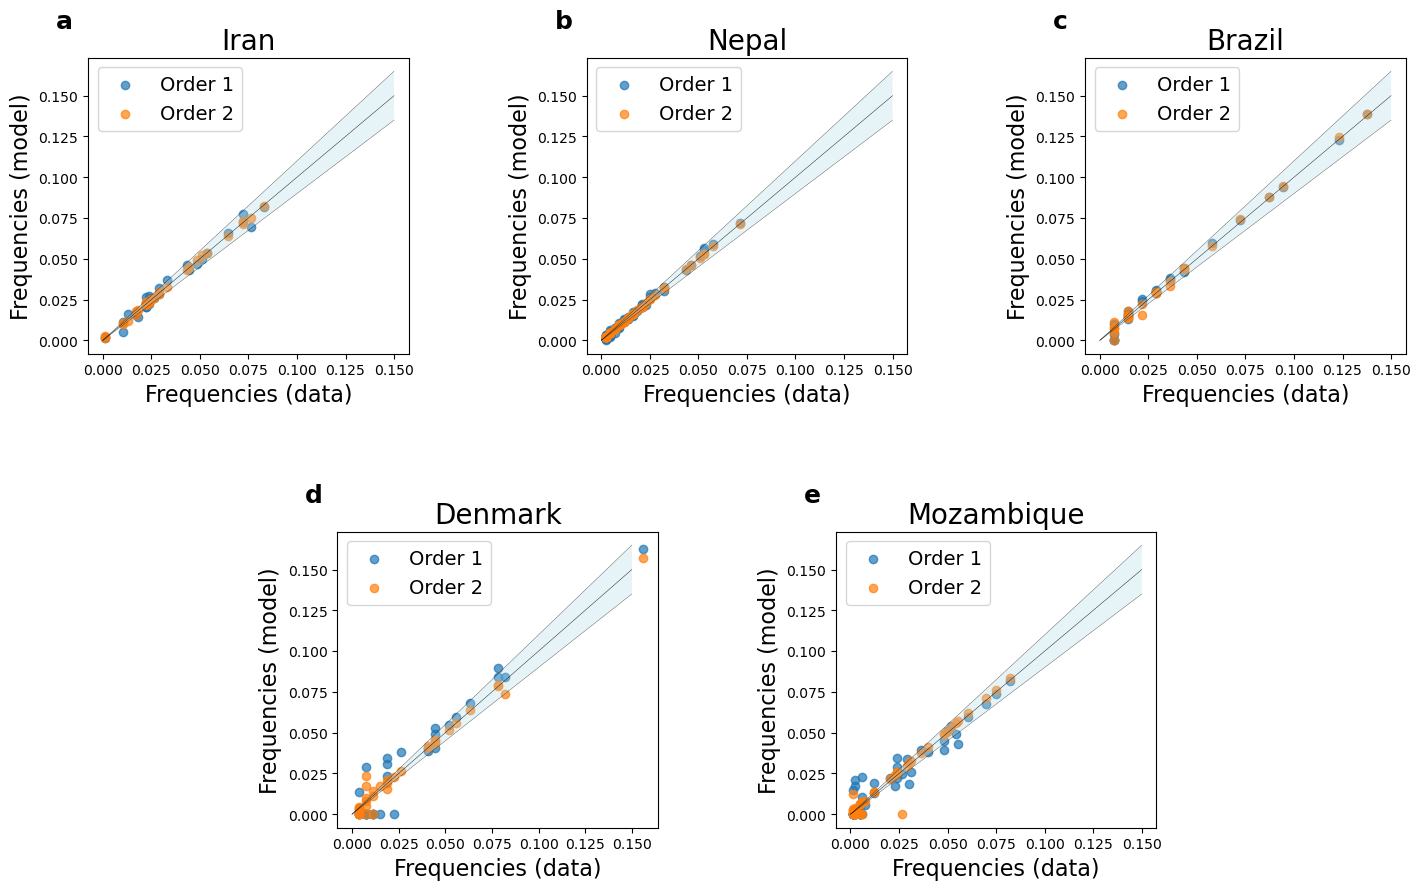

In [13]:
fig = plt.subplots(figsize = (17, 10))

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

plt.subplots_adjust(hspace = 0.6, wspace = 2.5)

ax = [ax1, ax2, ax3, ax4, ax5]
#MSE = np.array([0.00015/np.sqrt(len(Nepal.strain)), 0.0121/np.sqrt(len(Brazil.strain)), 0.0265/np.sqrt(len(Denmark.strain)), 
#                0.0316/np.sqrt(len(Mozambique.strain)), 0.00399/np.sqrt(len(Iran.strain))])

MSE = np.round(MSE, 4)

line = np.linspace(0, 0.15, 150)
line1 = np.linspace(0, 0.135, 150)
line2 = np.linspace(0, 0.165, 150)

name_country = ['Iran', 'Nepal', 'Brazil', 'Denmark', 'Mozambique']
label = ['a', 'b', 'c', 'd', 'e']
order = ['1', '2']

for i in range (0, 5):
    for j in range (0, 2):
        ax[i].scatter(np.array(country[i].cases), model_solution[j][i], alpha = .7, label = f'Order {order[j]}'
                     )
        print(f'Order {order[j]} \n MSE = {MSE[j][i]} \n E = {percent_good[j][i]} %')

    
    ax[i].plot(line, line, color = 'k', linewidth = .3)
    ax[i].plot(line, line1, color = 'k', linewidth = .2)
    ax[i].plot(line, line2, color = 'k', linewidth = .2)
    ax[i].fill_between(line, line1, line2, facecolor ='lightblue', alpha = 0.3)

    ax[i].set_xlabel('Frequencies (data)', fontsize = 16)
    ax[i].set_ylabel('Frequencies (model)', fontsize = 16)
    ax[i].set_title(f'{name_country[i]}', fontsize = 20)
    ax[i].text(-.1, 1.1, '{}'.format(label[i]),  transform=ax[i].transAxes, size=18, weight='bold')
    ax[i].legend(loc='upper left', fontsize = 14)
    
plt.show()
#plt.savefig("scatter_test.png".format(fig), format='png')